In [2]:
# imports
import time
import math
import json
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display as i_display

# plotting options
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams['figure.figsize']=(23,15)


# constants
months = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}

## <u><i>PREPROCESSING</i></u>

In [7]:
# get processed df
def get_df():
    df = pd.read_csv(r'D:\hash\HashCode\data\problem_1.csv')
    df.head()
    
    parts = df["Booking_Date"].str.split("-", n = 3, expand = True)
    df.head()
    arr = df.to_numpy()

    # separate date of order

    # old method
    # df["year"]= parts[2].astype('int')
    # df["month"]= parts[1].astype('int')

    # new method
    df["month"] = df["Fiscal Month"].str[0:3].astype(str).map(months).astype(int)
    df["year"] = df["Fiscal Month"].str[6:].astype(int)

    df["Fiscal Month"] = df["Fiscal Month"].apply(lambda x: f'{months[x[0:3]]}-{int("20"+x[-2]+x[-1])}')
    df["Fiscal Month"] = pd.to_datetime(df["Fiscal Month"], format="%m-%Y")
    df["fiscal_date"] = df["Fiscal Month"]
    df["quarter"] = df['Fiscal Month'].dt.quarter

    # df["booking_date"] = df["Booking_Date"].astype(str)
    df["booking_date"] = pd.to_datetime(df["Booking_Date"], format="%d-%m-%Y")

    df['prod_info'] = df['Business Unit'] + df['Product Family'] + df['PLID']

    df["booked_qty"] = df["Booked_Qty"]

    # replace features with numbers
    df['business_unit'], business_unit_u = pd.factorize(df['Business Unit'])
    df['product_family'], product_family_u = pd.factorize(df['Product Family'])
    df['plid'] = df['PLID']
    # df['plid'], plid_u = pd.factorize(df['PLID'])

    # add features
    # -------------------------------------------------------------------------------------
    # feature 1 [mean change across last]
    df["mean_across_quarter"] = df.groupby(['plid', 'quarter', 'year'], as_index=False).agg({'booked_qty': 'mean'})['booked_qty']

    # feature 2 [percentage change in feature 1]
    df['percentage_mean_change'] = df.groupby(['plid', 'quarter', 'year'])['mean_across_quarter'].pct_change()

    # fill Na's
    df["mean_across_quarter"] = df["mean_across_quarter"].fillna(0)
    df["percentage_mean_change"] = df["percentage_mean_change"].fillna(0)

    feature_df = df[["mean_across_quarter","percentage_mean_change"]]
    feature_array = feature_df.to_numpy(dtype = 'float64')
    inf_array = np.isinf(feature_array)
    feature_array = np.where(inf_array, 0, feature_array)
    feature_df = pd.DataFrame(feature_array, columns = ["mean_across_quarter","percentage_mean_change"])
    # -------------------------------------------------------------------------------------
    df["mean_across_quarter"] = feature_df["mean_across_quarter"]
    df["percentage_mean_change"] = feature_df["percentage_mean_change"]
    # -------------------------------------------------------------------------------------

    df['plid'], plid_u = pd.factorize(df['PLID'])

    # print results
    print("Unique values per feature:")
    print("  Business Units:", df['business_unit'].nunique())
    print("  Product Families:", df['product_family'].nunique())
    print("  PLIDs:", df['plid'].nunique())
    print("  Years:", df['year'].nunique())
    print("  Months:", df['month'].nunique())
    print(list(df['year'].unique()))

    # store numerifications into json
    f = open("numerifications.json", 'w')
    d = {"Business Unit": {}, "Product Family": {}, "PLID": {}}

    for i, x in enumerate(business_unit_u):
        d["Business Unit"][i] = x

    for i, x in enumerate(product_family_u):
        d["Product Family"][i] = x

    for i, x in enumerate(plid_u):
        d["PLID"][i] = x

    json.dump(d, f, indent = 4)
    f.close()

    # remove old features
    df.drop('Fiscal Quarter', inplace=True, axis=1)
    df.drop('Business Unit', inplace=True, axis=1)
    df.drop('PLID', inplace=True, axis=1)
    df.drop('Fiscal Month', inplace=True, axis=1)
    df.drop('prod_info', inplace=True, axis=1)
    df.drop('Product Family', inplace=True, axis=1)
    df.drop('Booking_Date', inplace=True, axis=1)
    df.drop('Booked_Qty', inplace=True, axis=1)

    data = df.copy()
    df.head()
    
    return data

In [8]:
# load the data frame
df = get_df()
df.head()

Unique values per feature:
  Business Units: 18
  Product Families: 73
  PLIDs: 250
  Years: 9
  Months: 12
[2022, 2002, 2008, 2007, 2011, 2012, 2015, 2014, 2013]


,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
0,8,2022,2022-08-01,3,2016-08-01,204,0,0,0,8.666667,0.000000
1,10,2022,2022-10-01,4,2016-10-01,564,0,0,0,505.000000,0.000000
2,9,2022,2022-09-01,3,2016-09-01,1476,0,0,0,12.333333,0.423077
3,8,2002,2002-08-01,3,2017-08-01,374,0,0,0,73.500000,0.000000
4,10,2002,2002-10-01,4,2017-10-01,6094,0,0,0,193.500000,0.000000


## <u><i>TRAINING [RANDOM FOREST REGRESSOR]</i></u>

In [9]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [17]:
# Split the data into training and test sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
features = ['plid','month','year']

In [18]:
rf_model.fit(train_data[features], train_data['booked_qty'])

RandomForestRegressor(n_estimators=1000, random_state=42)

In [20]:

# Evaluate the performance of the model on the test data
test_predictions = rf_model.predict(test_data[features])
print(test_data[features],test_predictions)
mae = mean_absolute_error(test_data['booked_qty'], test_predictions)
rmse = mean_squared_error(test_data['booked_qty'], test_predictions, squared=False)
print('MAE: {:.2f}'.format(mae))
print('RMSE: {:.2f}'.format(rmse))

       plid  month  year
107       1      1  2011
5481    142      1  2007
2848     90      3  2008
8760    206      6  2011
8117    191      3  2007
...     ...    ...   ...
6618    162     11  2022
10545   238      4  2011
5914    151      7  2008
6582    160      2  2012
10703   240     11  2022

[2200 rows x 3 columns] [  143.906        870.066        951.401      ... 18058.204
    60.232      24239.76753333]
MAE: 2827.94
RMSE: 8905.64


## <u><i>TRAINING [LSTM]</i></u>

In [21]:
df.reset_index()
df.head()

,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
0,8,2022,2022-08-01,3,2016-08-01,204,0,0,0,8.666667,0.000000
1,10,2022,2022-10-01,4,2016-10-01,564,0,0,0,505.000000,0.000000
2,9,2022,2022-09-01,3,2016-09-01,1476,0,0,0,12.333333,0.423077
3,8,2002,2002-08-01,3,2017-08-01,374,0,0,0,73.500000,0.000000
4,10,2002,2002-10-01,4,2017-10-01,6094,0,0,0,193.500000,0.000000


<Axes: xlabel='booking_date', ylabel='booked_qty'>

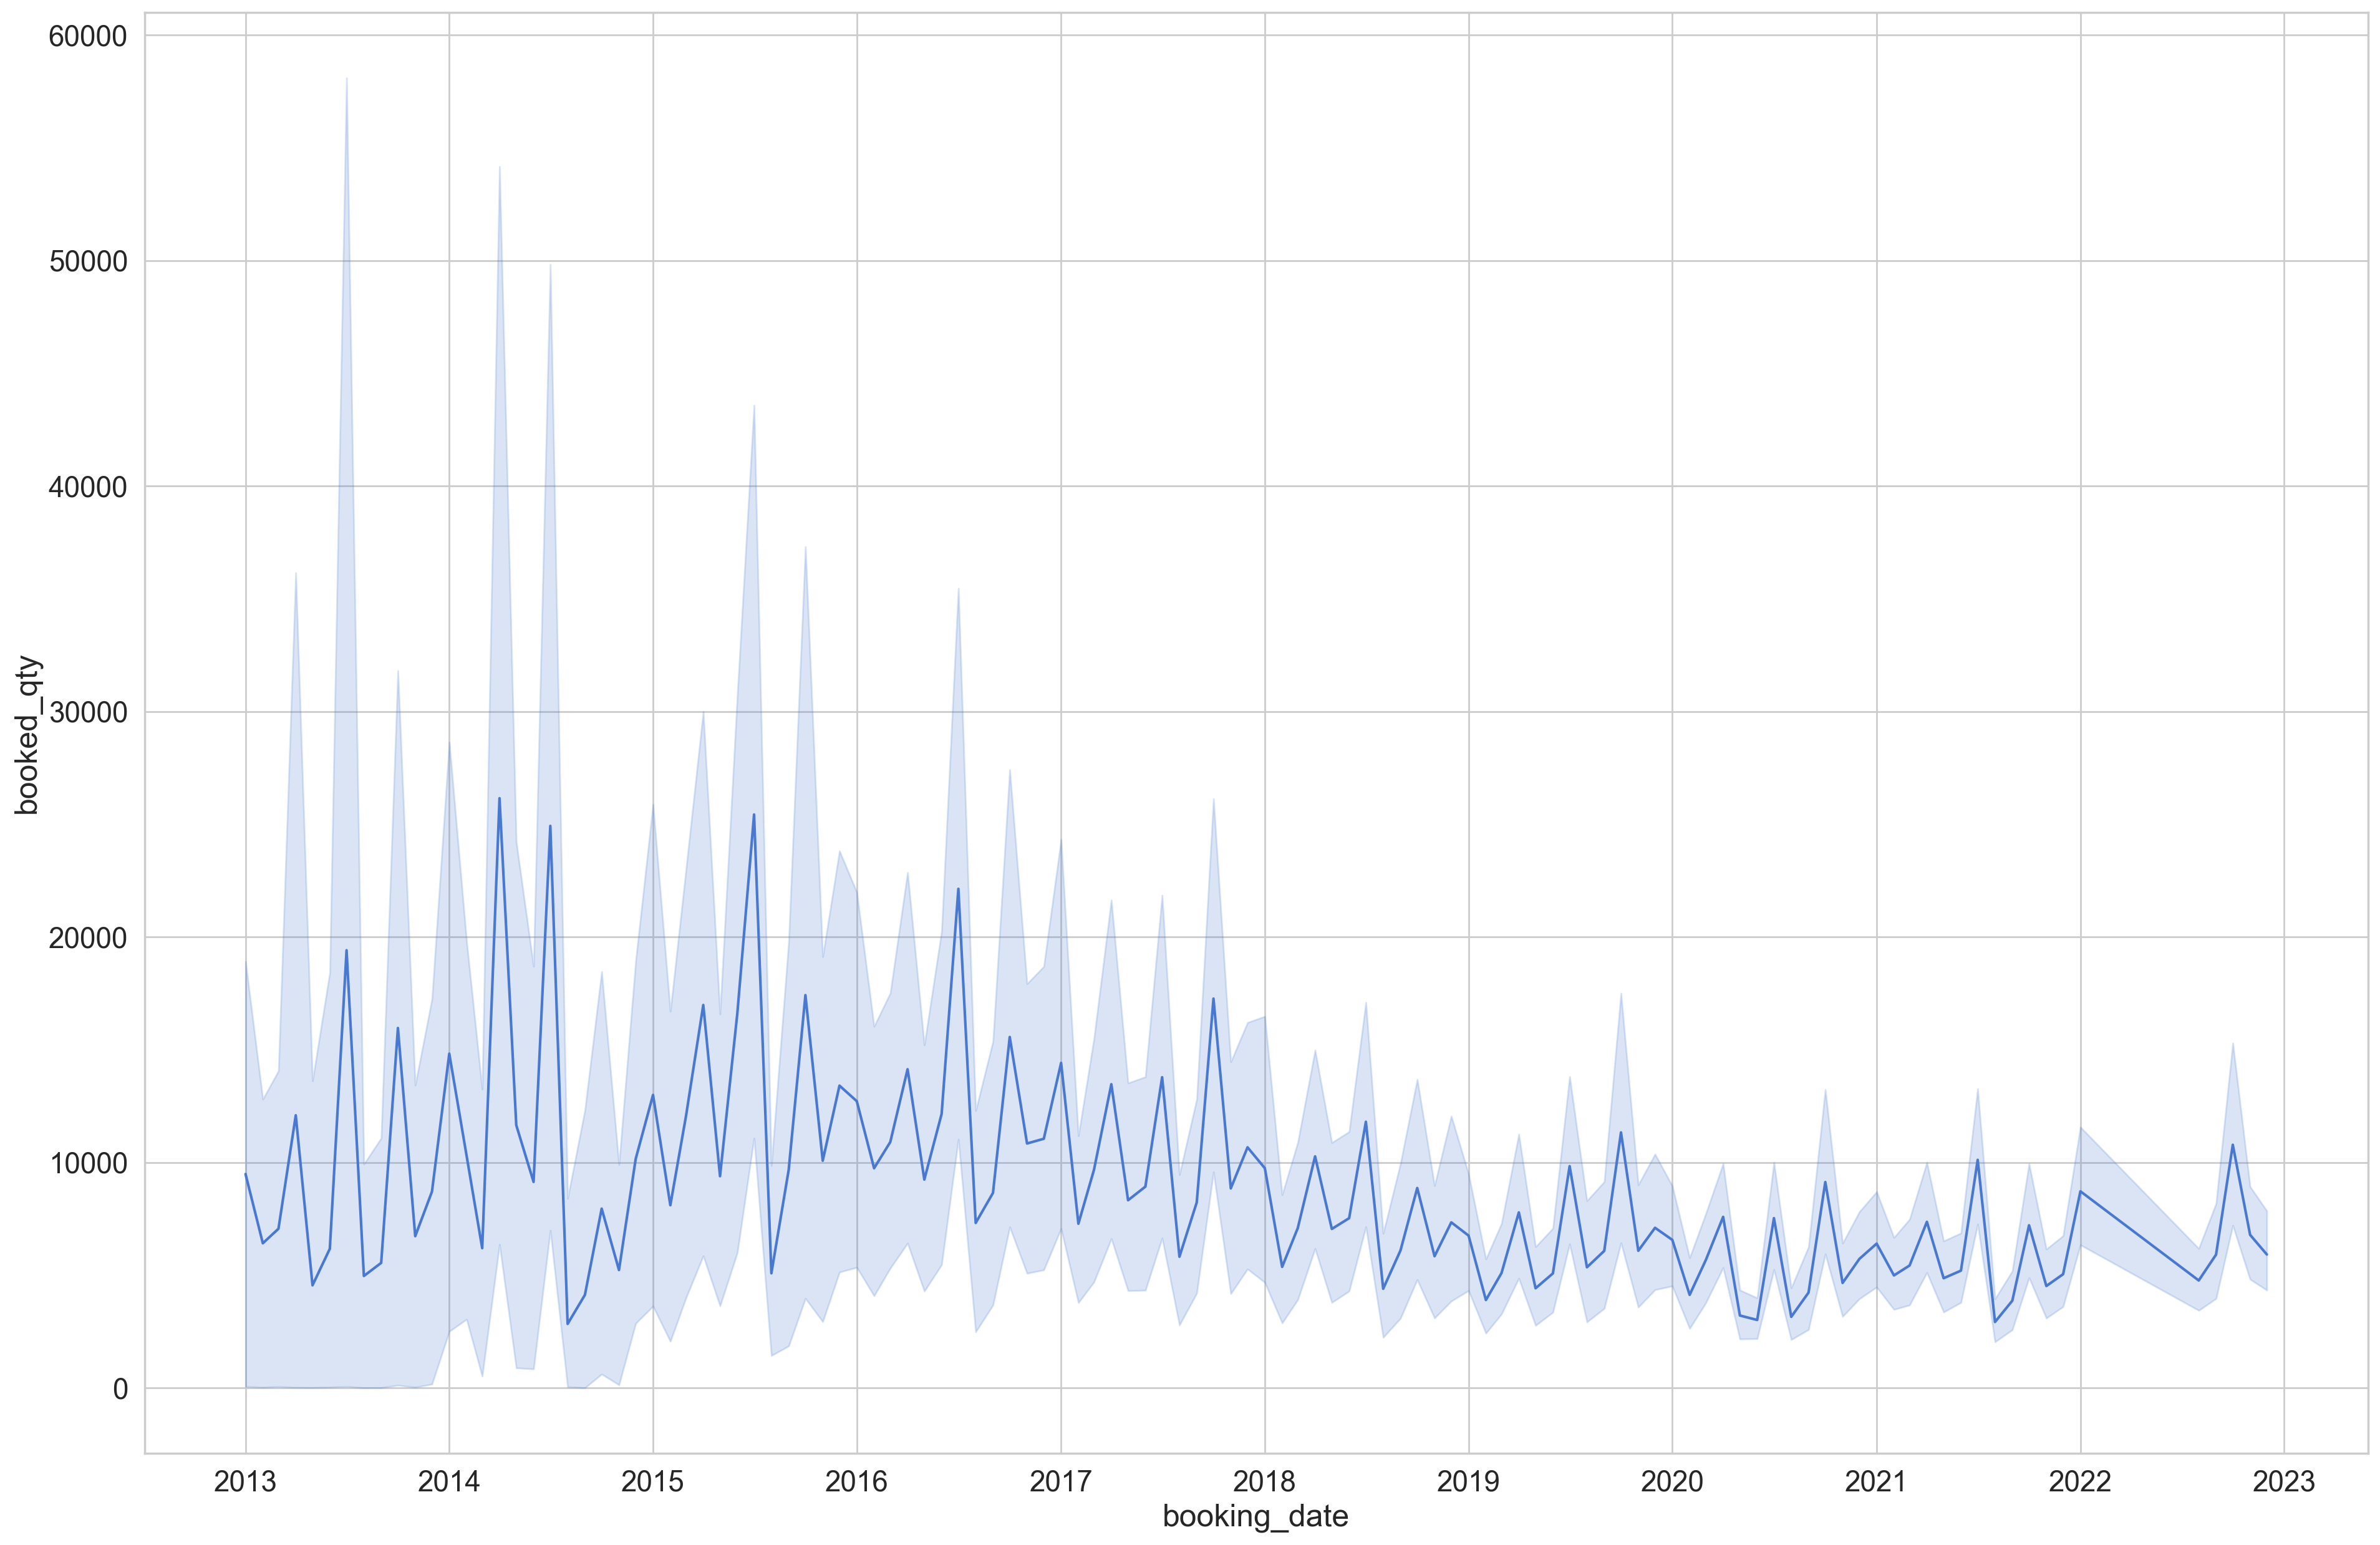

In [22]:
sns.lineplot(x=df["booking_date"], y="booked_qty", data=df)

## <u><i>TRAINING [PROPHET]</i></u>

In [23]:
df.tail()

,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
10991,6,2011,2011-06-01,2,2020-06-01,229,17,72,249,0.0,0.0
10992,5,2011,2011-05-01,2,2020-05-01,289,17,72,249,0.0,0.0
10993,7,2012,2012-07-01,3,2021-07-01,1231,17,72,249,0.0,0.0
10994,6,2012,2012-06-01,2,2021-06-01,591,17,72,249,0.0,0.0
10995,5,2012,2012-05-01,2,2021-05-01,601,17,72,249,0.0,0.0


In [24]:
# imports
# !pip install prophet
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [25]:
# uniques
no_products = df["plid"].nunique()
no_fams = df["product_family"].nunique()
no_business_units = df["business_unit"].nunique()
print("unique products:", no_products)
print("unique families:", no_fams)
print("unique business units:", no_business_units)

unique products: 250
unique families: 73
unique business units: 18


In [63]:
# regressing by product family
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_scores = []
rmse_scores = []
num = {}
with open("numerifications.json", 'r') as f:
    num = json.load(f)
 
train_datas, test_datas = train_test_split(df, test_size=0.15, shuffle=True)

for i in range(no_fams):
    print(i)
    train_df = train_datas.loc[train_datas['product_family'] == i][["booking_date", "booked_qty"]]
    train_df.columns = ["ds", "y"]
    train_df = train_df.sort_values(by='ds')

    test_df = test_datas.loc[test_datas['product_family'] == i][["booking_date", "booked_qty"]]
    test_df.columns = ["ds", "y"]
    test_df = test_df.sort_values(by='ds')
    test_df.head()
    train_df = train_df.reset_index()

    train_df.drop("index", inplace = True, axis = 1)
    # print(train_df,'asiduhanisugydasd')
    # print("before mean:", train_df.shape)
    
    after_mean = train_df.groupby("ds")["y"].mean()
    after_mean = after_mean.reset_index()
    after_mean.columns = ["ds", 'y']

    # print("after mean:", after_mean.shape)

    model = Prophet()
    model.fit(after_mean)


    # extrapolating output
    # future = pd.DataFrame(pd.date_range(start='2012-01-01', end='2024-12-31', freq='MS'), columns = ["ds"])
    forecast = model.predict(test_df)
    # print(forecast)
    # print(after_mean['y'],train_df['y'])
    # # print(after_mean)
    # mae = mean_absolute_error(after_mean['y'], train_df['y'])
    # rmse = np.sqrt(mean_squared_error(after_mean['y'], train_df['y']))
    # mae_scores.append(mae)
    # rmse_scores.append(rmse)
    # model.plot(forecast)

    # fam_name = num["Product Family"][str(i)]
    # plt.savefig(f"prophet_results/{str(fam_name)}.png")


01:48:53 - cmdstanpy - INFO - Chain [1] start processing


0


01:48:54 - cmdstanpy - INFO - Chain [1] done processing
01:48:54 - cmdstanpy - INFO - Chain [1] start processing


1


01:48:54 - cmdstanpy - INFO - Chain [1] done processing
01:48:54 - cmdstanpy - INFO - Chain [1] start processing


2


01:48:54 - cmdstanpy - INFO - Chain [1] done processing
01:48:54 - cmdstanpy - INFO - Chain [1] start processing


3


01:48:54 - cmdstanpy - INFO - Chain [1] done processing
01:48:55 - cmdstanpy - INFO - Chain [1] start processing


4


01:48:55 - cmdstanpy - INFO - Chain [1] done processing
01:48:55 - cmdstanpy - INFO - Chain [1] start processing


5


01:48:55 - cmdstanpy - INFO - Chain [1] done processing
01:48:55 - cmdstanpy - INFO - Chain [1] start processing


6


01:49:02 - cmdstanpy - INFO - Chain [1] done processing
01:49:03 - cmdstanpy - INFO - Chain [1] start processing


7


01:49:03 - cmdstanpy - INFO - Chain [1] done processing
01:49:03 - cmdstanpy - INFO - Chain [1] start processing


8


01:49:03 - cmdstanpy - INFO - Chain [1] done processing
01:49:03 - cmdstanpy - INFO - Chain [1] start processing


9


01:49:04 - cmdstanpy - INFO - Chain [1] done processing
01:49:04 - cmdstanpy - INFO - Chain [1] start processing


10


01:49:04 - cmdstanpy - INFO - Chain [1] done processing
01:49:04 - cmdstanpy - INFO - Chain [1] start processing
01:49:04 - cmdstanpy - INFO - Chain [1] done processing


11
12


01:49:04 - cmdstanpy - INFO - Chain [1] start processing
01:49:04 - cmdstanpy - INFO - Chain [1] done processing
01:49:04 - cmdstanpy - INFO - Chain [1] start processing


13


01:49:05 - cmdstanpy - INFO - Chain [1] done processing
01:49:05 - cmdstanpy - INFO - Chain [1] start processing
01:49:05 - cmdstanpy - INFO - Chain [1] done processing


14
15


01:49:05 - cmdstanpy - INFO - Chain [1] start processing
01:49:05 - cmdstanpy - INFO - Chain [1] done processing
01:49:05 - cmdstanpy - INFO - Chain [1] start processing
01:49:05 - cmdstanpy - INFO - Chain [1] done processing


16
17


01:49:05 - cmdstanpy - INFO - Chain [1] start processing
01:49:05 - cmdstanpy - INFO - Chain [1] done processing
01:49:05 - cmdstanpy - INFO - Chain [1] start processing


18


01:49:06 - cmdstanpy - INFO - Chain [1] done processing
01:49:06 - cmdstanpy - INFO - Chain [1] start processing
01:49:06 - cmdstanpy - INFO - Chain [1] done processing


19


01:49:06 - cmdstanpy - INFO - Chain [1] start processing


20


01:49:06 - cmdstanpy - INFO - Chain [1] done processing
01:49:06 - cmdstanpy - INFO - Chain [1] start processing


21


01:49:07 - cmdstanpy - INFO - Chain [1] done processing
01:49:07 - cmdstanpy - INFO - Chain [1] start processing


22


01:49:07 - cmdstanpy - INFO - Chain [1] done processing
01:49:07 - cmdstanpy - INFO - Chain [1] start processing


23


01:49:07 - cmdstanpy - INFO - Chain [1] done processing
01:49:07 - cmdstanpy - INFO - Chain [1] start processing


24


01:49:08 - cmdstanpy - INFO - Chain [1] done processing
01:49:08 - cmdstanpy - INFO - Chain [1] start processing


25


01:49:17 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] start processing


26


01:49:17 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] start processing


27


01:49:17 - cmdstanpy - INFO - Chain [1] done processing
01:49:17 - cmdstanpy - INFO - Chain [1] start processing


28


01:49:18 - cmdstanpy - INFO - Chain [1] done processing
01:49:18 - cmdstanpy - INFO - Chain [1] start processing


29


01:49:18 - cmdstanpy - INFO - Chain [1] done processing
01:49:18 - cmdstanpy - INFO - Chain [1] start processing
01:49:18 - cmdstanpy - INFO - Chain [1] done processing


30


01:49:18 - cmdstanpy - INFO - Chain [1] start processing


31


01:49:18 - cmdstanpy - INFO - Chain [1] done processing
01:49:19 - cmdstanpy - INFO - Chain [1] start processing


32


01:49:19 - cmdstanpy - INFO - Chain [1] done processing
01:49:19 - cmdstanpy - INFO - Chain [1] start processing
01:49:19 - cmdstanpy - INFO - Chain [1] done processing


33
34


01:49:19 - cmdstanpy - INFO - Chain [1] start processing
01:49:19 - cmdstanpy - INFO - Chain [1] done processing
01:49:19 - cmdstanpy - INFO - Chain [1] start processing


35


01:49:20 - cmdstanpy - INFO - Chain [1] done processing
01:49:20 - cmdstanpy - INFO - Chain [1] start processing


36


01:49:20 - cmdstanpy - INFO - Chain [1] done processing
01:49:20 - cmdstanpy - INFO - Chain [1] start processing
01:49:20 - cmdstanpy - INFO - Chain [1] done processing


37
38


01:49:20 - cmdstanpy - INFO - Chain [1] start processing
01:49:20 - cmdstanpy - INFO - Chain [1] done processing
01:49:21 - cmdstanpy - INFO - Chain [1] start processing


39


01:49:21 - cmdstanpy - INFO - Chain [1] done processing
01:49:21 - cmdstanpy - INFO - Chain [1] start processing
01:49:21 - cmdstanpy - INFO - Chain [1] done processing


40
41


01:49:21 - cmdstanpy - INFO - Chain [1] start processing
01:49:21 - cmdstanpy - INFO - Chain [1] done processing
01:49:21 - cmdstanpy - INFO - Chain [1] start processing
01:49:21 - cmdstanpy - INFO - Chain [1] done processing


42
43


01:49:21 - cmdstanpy - INFO - Chain [1] start processing
01:49:30 - cmdstanpy - INFO - Chain [1] done processing
01:49:30 - cmdstanpy - INFO - Chain [1] start processing


44


01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing


45


01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing


46


01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing


47


01:49:34 - cmdstanpy - INFO - Chain [1] done processing
01:49:34 - cmdstanpy - INFO - Chain [1] start processing


48


01:49:35 - cmdstanpy - INFO - Chain [1] done processing
01:49:35 - cmdstanpy - INFO - Chain [1] start processing


49


01:49:35 - cmdstanpy - INFO - Chain [1] done processing
01:49:35 - cmdstanpy - INFO - Chain [1] start processing


50


01:49:44 - cmdstanpy - INFO - Chain [1] done processing
01:49:44 - cmdstanpy - INFO - Chain [1] start processing


51


01:49:44 - cmdstanpy - INFO - Chain [1] done processing
01:49:44 - cmdstanpy - INFO - Chain [1] start processing


52


01:49:44 - cmdstanpy - INFO - Chain [1] done processing
01:49:44 - cmdstanpy - INFO - Chain [1] start processing
01:49:44 - cmdstanpy - INFO - Chain [1] done processing


53
54


01:49:45 - cmdstanpy - INFO - Chain [1] start processing
01:49:45 - cmdstanpy - INFO - Chain [1] done processing
01:49:45 - cmdstanpy - INFO - Chain [1] start processing


55


01:49:45 - cmdstanpy - INFO - Chain [1] done processing
01:49:45 - cmdstanpy - INFO - Chain [1] start processing
01:49:45 - cmdstanpy - INFO - Chain [1] done processing


56
57


01:49:45 - cmdstanpy - INFO - Chain [1] start processing
01:49:46 - cmdstanpy - INFO - Chain [1] done processing
01:49:46 - cmdstanpy - INFO - Chain [1] start processing


58


01:49:46 - cmdstanpy - INFO - Chain [1] done processing
01:49:46 - cmdstanpy - INFO - Chain [1] start processing


59


01:49:46 - cmdstanpy - INFO - Chain [1] done processing
01:49:46 - cmdstanpy - INFO - Chain [1] start processing


60


01:49:46 - cmdstanpy - INFO - Chain [1] done processing
01:49:47 - cmdstanpy - INFO - Chain [1] start processing


61


01:49:47 - cmdstanpy - INFO - Chain [1] done processing
01:49:47 - cmdstanpy - INFO - Chain [1] start processing


62


01:49:47 - cmdstanpy - INFO - Chain [1] done processing
01:49:47 - cmdstanpy - INFO - Chain [1] start processing


63


01:49:47 - cmdstanpy - INFO - Chain [1] done processing
01:49:47 - cmdstanpy - INFO - Chain [1] start processing


64


01:49:47 - cmdstanpy - INFO - Chain [1] done processing
01:49:48 - cmdstanpy - INFO - Chain [1] start processing


65


01:49:48 - cmdstanpy - INFO - Chain [1] done processing
01:49:48 - cmdstanpy - INFO - Chain [1] start processing
01:49:48 - cmdstanpy - INFO - Chain [1] done processing


66
67


01:49:48 - cmdstanpy - INFO - Chain [1] start processing
01:49:48 - cmdstanpy - INFO - Chain [1] done processing
01:49:48 - cmdstanpy - INFO - Chain [1] start processing


68


01:49:57 - cmdstanpy - INFO - Chain [1] done processing
01:49:57 - cmdstanpy - INFO - Chain [1] start processing


69


01:49:57 - cmdstanpy - INFO - Chain [1] done processing
01:49:57 - cmdstanpy - INFO - Chain [1] start processing
01:49:57 - cmdstanpy - INFO - Chain [1] done processing


70


01:49:57 - cmdstanpy - INFO - Chain [1] start processing
01:49:57 - cmdstanpy - INFO - Chain [1] done processing


71
72


01:49:57 - cmdstanpy - INFO - Chain [1] start processing
01:49:58 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
mae = mean_absolute_error(test_df['y'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast['yhat']))
print(f"For Product Family {i}, MAE: {mae}, RMSE: {rmse}")

For Product Family 72, MAE: 165.39003261767962, RMSE: 204.88616218160533


In [27]:
oos_mae = mean_absolute_error(df["booked_qty"][-365:], forecast['yhat'][-365:])
oos_rmse = np.sqrt(mean_squared_error(df['y'][-365:], forecast['yhat'][-365:]))
print('Out-of-sample MAE:', oos_mae)
print('Out-of-sample RMSE:', oos_rmse)

KeyError: 'y'

In [ ]:
!zip -r prophet_results.zip prophet_results

updating: prophet_results/ (stored 0%)
updating: prophet_results/CTSPS.png (deflated 3%)
updating: prophet_results/CAT8300.png (deflated 5%)
updating: prophet_results/8000.png (deflated 3%)
updating: prophet_results/IE4000.png (deflated 3%)
updating: prophet_results/C9115AX.png (deflated 4%)
updating: prophet_results/C9120AX.png (deflated 4%)
updating: prophet_results/A9K1000.png (deflated 2%)
updating: prophet_results/NCS1000.png (deflated 3%)
updating: prophet_results/C9400.png (deflated 2%)
updating: prophet_results/NCS5500.png (deflated 2%)
updating: prophet_results/PHONVID.png (deflated 2%)
updating: prophet_results/HXCPU.png (deflated 3%)
updating: prophet_results/A9K9000.png (deflated 2%)
updating: prophet_results/NCS540.png (deflated 3%)
updating: prophet_results/NCS4200.png (deflated 4%)
updating: prophet_results/CAT8200.png (deflated 8%)
updating: prophet_results/CBR8.png (deflated 2%)
updating: prophet_results/SFP10G.png (deflated 3%)
updating: prophet_results/ONS.png (defla